In [7]:
import json
import os
import re
from typing import Dict, Any, Union, Tuple
from typing import List

import pandas as pd
from matplotlib import pyplot as plt
from pandas import DataFrame

In [8]:



def load_json_data(file_path: str) -> pd.DataFrame:
    """Load data from JSON file."""
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    with open(file_path, 'r') as f:
        data = json.load(f)

    # Assuming that all items in the JSON file have the same structure
    keys: List[str] = list(data[0].keys())
    filtered_data: List[Dict[str, Any]] = [{key: item[key] for key in keys} for
                                           item in data]

    df: pd.DataFrame = pd.DataFrame(filtered_data)

    return df


def convert_to_universal_time_format(df: pd.DataFrame) -> pd.DataFrame:
    # Identify columns that match a regular expression pattern for "time"
    time_columns: List[str] = [col for col in df.columns if
                               re.match(r'.*time.*', col, re.IGNORECASE)]

    # Convert identified columns to datetime format and extract year and month
    for col in time_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].dt.to_period('M')

    # Group by year and month, and calculate the median of each group
    for col in time_columns:
        df = df.groupby(col).median().reset_index()

    return df


def rename_time_columns_to_universal_format(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process time columns in a dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe.

    Returns:
    pd.DataFrame: The processed dataframe.
    """
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*time.*', col, re.IGNORECASE)]

    df.rename(columns={time_cols[0]: 'time'}, inplace=True)

    # Handle multiple time indices
    if len(time_cols) > 1:
        for i, col in enumerate(time_cols[1:], start=1):
            df.rename(columns={col: f'time{i}'}, inplace=True)

    return df


def merge_dataframes_by_time(df1: pd.DataFrame,
                             df2: pd.DataFrame) -> pd.DataFrame:
    """
    Merge two dataframes by time.

    Parameters:
    df1 (pd.DataFrame): The first dataframe.
    df2 (pd.DataFrame): The second dataframe.

    Returns:
    pd.DataFrame: The merged dataframe.
    """
    # Process time columns in both dataframes
    df1 = rename_time_columns_to_universal_format(df1)
    df2 = rename_time_columns_to_universal_format(df2)

    # Merge dataframes
    merged_df: pd.DataFrame = pd.merge(df1, df2, how='inner')

    return merged_df


def filter_by_years(df: pd.DataFrame,
                    years_to_analyze: List[int]) -> pd.DataFrame:
    """
    Filters a DataFrame based on a list of years.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to filter.
        years_to_analyze (List[int]): The list of years to keep.
        
    Returns:
        filtered_df (pd.DataFrame): The filtered DataFrame.
    """
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*time.*', col, re.IGNORECASE)]

    filtered_df: DataFrame = DataFrame()

    for col in time_cols:
        filtered_df = df[df[col].dt.year.isin(years_to_analyze)]

    return filtered_df


def calculate_correlation(df: pd.DataFrame, col1: str, col2: str) -> Tuple[
    Union[float, DataFrame], float, float]:
    """
    Calculate the correlation between two columns in a dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe.
    col1 (str): The name of the first column.
    col2 (str): The name of the second column.

    Returns:
    tuple: A tuple containing the Pearson, Kendall, and Spearman correlation coefficients.
    """
    correlation: Union[float, DataFrame] = df[col1].corr(df[col2])
    tau = df[col1].corr(df[col2], method='kendall')
    kelman = df[col1].corr(df[col2], method='spearman')
    return correlation, tau, kelman


def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str) -> None:
    """
    Function to plot a scatter plot from a dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    x_col (str): Name of the column to be plotted on the x-axis.
    y_col (str): Name of the column to be plotted on the y-axis.

    Returns:
    None
    """
    # Check if columns exist in dataframe
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError("One or both columns do not exist in the dataframe")

    # Check if columns contain numerical data
    if not pd.api.types.is_numeric_dtype(
            df[x_col]) or not pd.api.types.is_numeric_dtype(df[y_col]):
        raise TypeError("One or both columns are not numeric")

    plt.figure(figsize=(10, 8))
    plt.scatter(df[x_col], df[y_col])
    plt.title(f'Scatter plot of {x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()


def plot_scatter_multiple(df: pd.DataFrame, x_col: str,
                          y_cols: List[str]) -> None:
    """
    Function to plot multiple scatter plots from a dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    x_col (str): Name of the column to be plotted on the x-axis.
    y_cols (List[str]): List of column names to be plotted on the y-axis.

    Returns:
    None
    """
    # Check if x column exists in dataframe
    if x_col not in df.columns:
        raise ValueError("X column does not exist in the dataframe")

    # Check if x column contains numerical data
    if not pd.api.types.is_numeric_dtype(df[x_col]):
        raise TypeError("X column is not numeric")

    # Check if all y columns exist in dataframe and contain numerical data
    for y_col in y_cols:
        if y_col not in df.columns:
            raise ValueError(
                f"Y column {y_col} does not exist in the dataframe")
        if not pd.api.types.is_numeric_dtype(df[y_col]):
            raise TypeError(f"Y column {y_col} is not numeric")

    plt.figure(figsize=(10, 8))
    for y_col in y_cols:
        plt.scatter(df[x_col], df[y_col], label=y_col)
    plt.title(f'Scatter plot of {x_col} vs multiple y-columns')
    plt.xlabel(x_col)
    plt.ylabel('Values')
    plt.legend()
    plt.show()


def calculate_correlations_and_plot(df: pd.DataFrame, col_list1: List[str],
                                    col_list2: List[str]) -> None:
    """
    Calculate correlations between each pair of columns from two lists in a DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    col_list1 (List[str]): List of column names to correlate with col_list2.
    col_list2 (List[str]): List of column names to correlate with col_list1.
    """
    for col1 in col_list1:
        for col2 in col_list2:
            if col1 != col2:
                print(
                    f"Correlation {col1} vs {col2}: {calculate_correlation(df, col1, col2)}")
            else:
                col_list2.remove(col1)
        plot_scatter_multiple(df, col1, col_list2)


def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function removes columns from a DataFrame that are not of type float or int.
    The first column is ignored.

    Parameters:
    df (pd.DataFrame): Input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with non-numeric columns removed.
    """
    # Ignore the first column
    cols_to_drop = []
    for col in df.columns[1:]:
        if df[col].dtype not in ['float64', 'int64']:
            cols_to_drop.append(col)

    return df.drop(cols_to_drop, axis=1)


# TODO: Make it not so general (SRP)
def process(solar_data_file: os.path,
            satellite_data_file: os.path):
    # Define the list of years to analyze
    years_to_analyze: List[int] = [2023, 2019, 2014]

    df_solar: DataFrame = load_json_data(solar_data_file)
    df_solar = convert_to_universal_time_format(df_solar)

    solar_column_names: List[str] = [col for col in df_solar.columns if
                                     not re.match(r'.*time.*', col,
                                                  re.IGNORECASE)]

    df_satellite: DataFrame = pd.read_csv(satellite_data_file)
    df_satellite = clean_dataframe(df_satellite)
    df_satellite = convert_to_universal_time_format(df_satellite)

    filter_by_years(df_satellite, years_to_analyze)

    satellite_column_names: List[str] = [col for col in df_satellite.columns if
                                         not re.match(r'.*time.*', col,
                                                      re.IGNORECASE)]

    df_solar_satellite_merged: pd.DataFrame = merge_dataframes_by_time(
        df_solar,
        df_satellite)

    calculate_correlations_and_plot(df_solar_satellite_merged,
                                    satellite_column_names,
                                    solar_column_names
                                    )

Correlation Battery vs ssn: (-0.13972807193454626, -0.07171902055538998, -0.08303782254463078)
Correlation Battery vs smoothed_ssn: (-0.3107871416588979, -0.19149688109734606, -0.23046387095990112)
Correlation Battery vs observed_swpc_ssn: (-0.14741505568840838, -0.0693271127837246, -0.08019842915534707)
Correlation Battery vs smoothed_swpc_ssn: (-0.30676039183936116, -0.19155146193958233, -0.23046707591996798)
Correlation Battery vs f10.7: (-0.1867031483558193, -0.11538187313793137, -0.13664513560910088)
Correlation Battery vs smoothed_f10.7: (-0.2922258172729578, -0.19221009355148566, -0.23053761888746685)


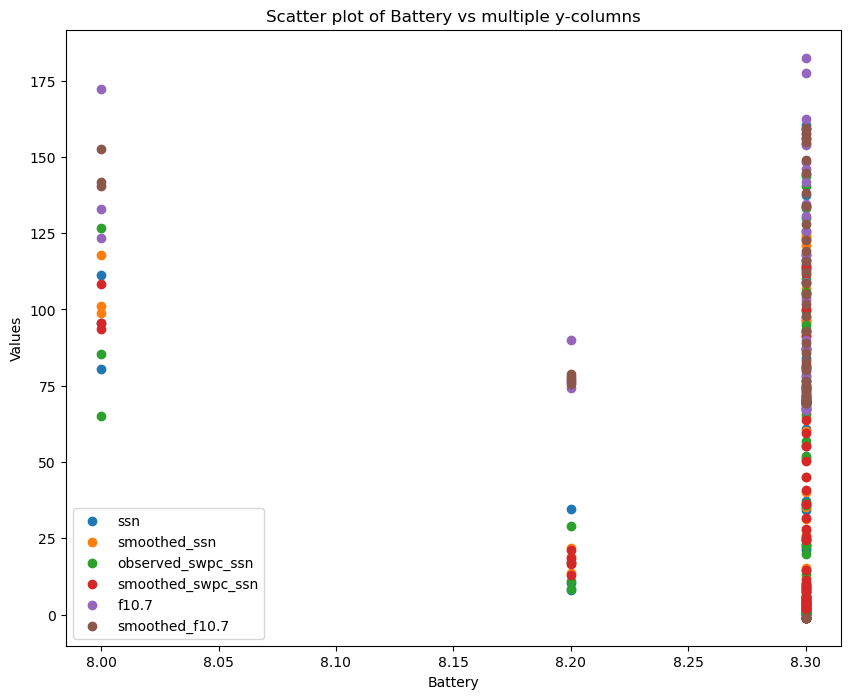

/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Correlation 3.3V vs ssn: (2.8928015357738235e-17, nan, nan)
Correlation 3.3V vs smoothed_ssn: (3.76514328421923e-18, nan, nan)
Correlation 3.3V vs observed_swpc_ssn: (4.8105662410419635e-17, nan, nan)
Correlation 3.3V vs smoothed_swpc_ssn: (6.426718068920605e-17, nan, nan)
Correlation 3.3V vs f10.7: (3.2417595354086603e-16, nan, nan)
Correlation 3.3V vs smoothed_f10.7: (-6.150202922174086e-17, nan, nan)


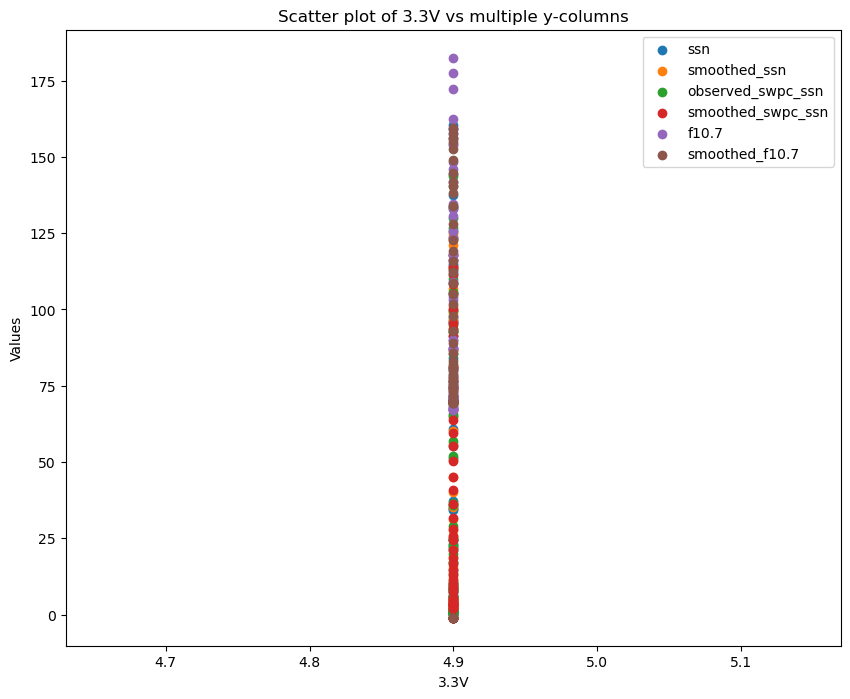

/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Correlation 5V vs ssn: (nan, nan, nan)
Correlation 5V vs smoothed_ssn: (nan, nan, nan)
Correlation 5V vs observed_swpc_ssn: (nan, nan, nan)
Correlation 5V vs smoothed_swpc_ssn: (nan, nan, nan)
Correlation 5V vs f10.7: (nan, nan, nan)
Correlation 5V vs smoothed_f10.7: (nan, nan, nan)


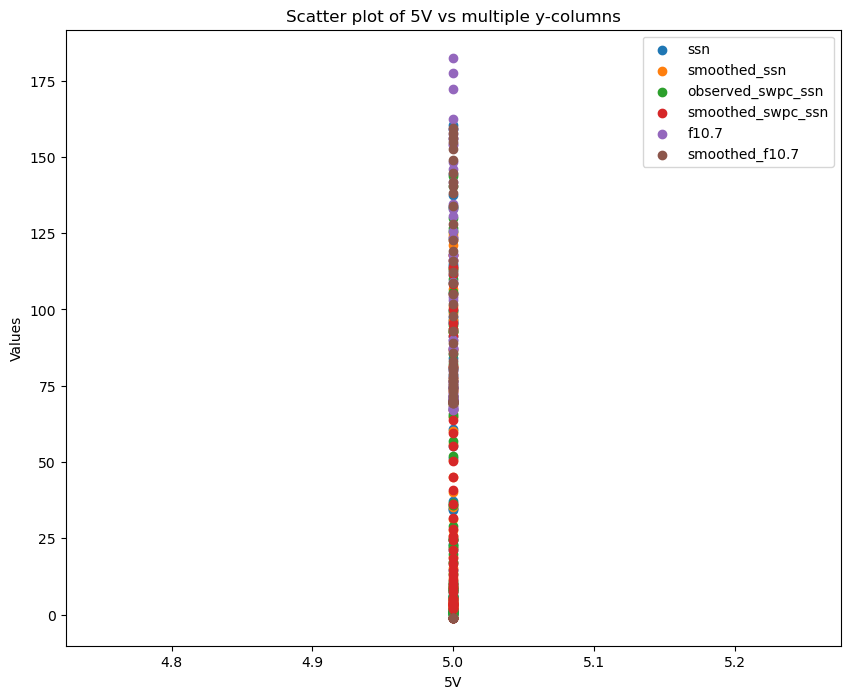

Correlation Battery Bus vs ssn: (0.34306849393439953, 0.4049767733768524, 0.5803568962663838)
Correlation Battery Bus vs smoothed_ssn: (0.42817412485261824, 0.3243895486139028, 0.4851010276630374)
Correlation Battery Bus vs observed_swpc_ssn: (0.3559943732328977, 0.4133218740325417, 0.588494211778555)
Correlation Battery Bus vs smoothed_swpc_ssn: (0.42587873675059357, 0.3239004978298801, 0.4843268039264007)
Correlation Battery Bus vs f10.7: (0.3728133540650135, 0.4283672905705466, 0.5929613627637287)
Correlation Battery Bus vs smoothed_f10.7: (0.2931480075767957, 0.3541896209252578, 0.5028195083043857)


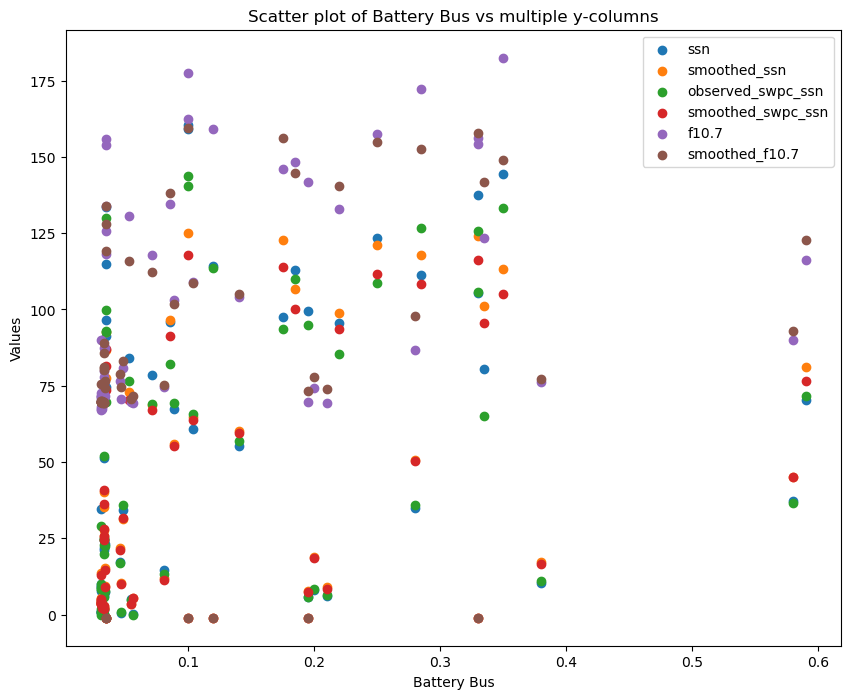

Correlation Battery Bus vs ssn: (-0.06683376633403207, 0.010362783325858637, 0.01890182419506821)
Correlation Battery Bus vs smoothed_ssn: (-0.4318836359962252, -0.38577141285375294, -0.4630648824912795)
Correlation Battery Bus vs observed_swpc_ssn: (-0.07029979246495732, 0.015552979393339167, 0.024989167476471796)
Correlation Battery Bus vs smoothed_swpc_ssn: (-0.42751678879603255, -0.3858813662300355, -0.4630713221316906)
Correlation Battery Bus vs f10.7: (-0.08261104839657904, 0.030026592987043806, 0.03720203986654775)
Correlation Battery Bus vs smoothed_f10.7: (-0.5197758921276953, -0.3767713046211193, -0.4512027226189621)


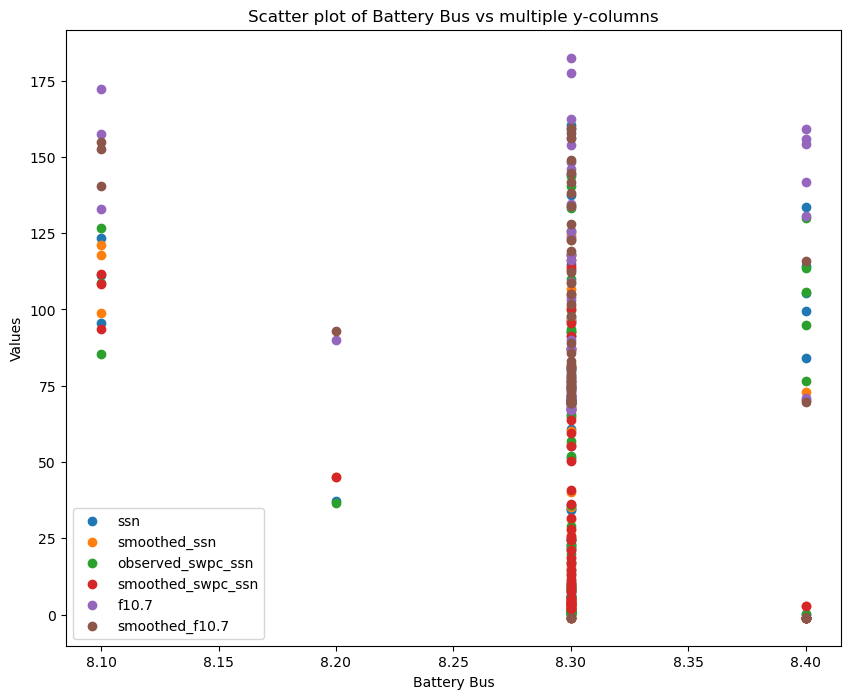

Correlation 40379.median vs ssn: (0.6243048605874743, 0.5018439143801292, 0.7163503059493702)
Correlation 40379.median vs smoothed_ssn: (0.5355421465189284, 0.3596020707860973, 0.5155012016313268)
Correlation 40379.median vs observed_swpc_ssn: (0.6321956901806866, 0.5032629176230278, 0.7167970706017049)
Correlation 40379.median vs smoothed_swpc_ssn: (0.5433229628854387, 0.3591354125284485, 0.5153137340948172)
Correlation 40379.median vs f10.7: (0.5811577558184146, 0.48725407978178686, 0.6976447035447789)
Correlation 40379.median vs smoothed_f10.7: (0.26696916594408804, 0.3877835347532134, 0.5260963016668757)


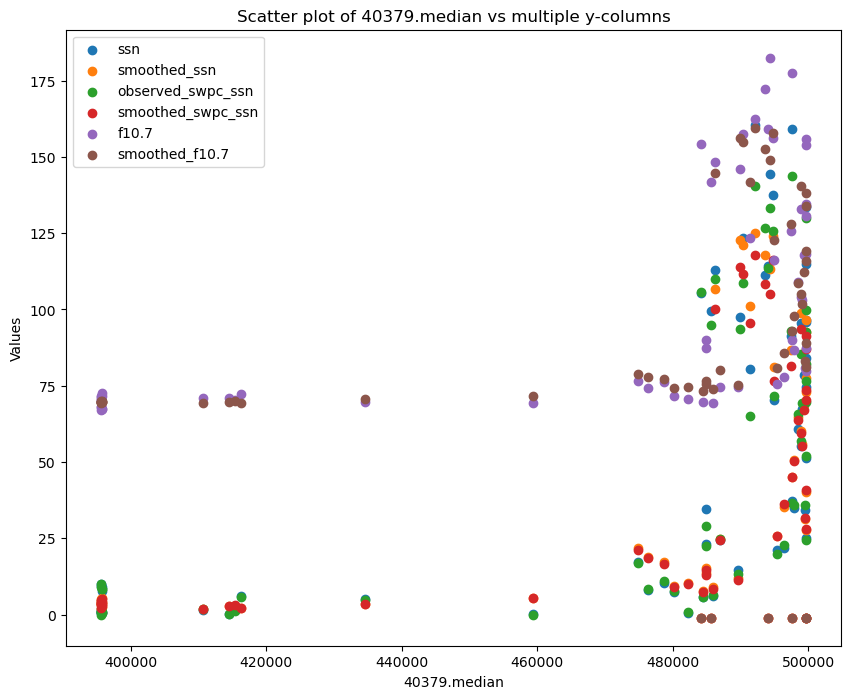

Correlation 40379.freemem vs ssn: (-0.4171539430821123, -0.33629457280083896, -0.470200970540779)
Correlation 40379.freemem vs smoothed_ssn: (-0.45674100572623005, -0.28642012982340154, -0.4225758591535156)
Correlation 40379.freemem vs observed_swpc_ssn: (-0.4138804527967414, -0.32492199374841163, -0.4675030159062552)
Correlation 40379.freemem vs smoothed_swpc_ssn: (-0.45987879739450194, -0.28592180280001006, -0.4214803184717404)
Correlation 40379.freemem vs f10.7: (-0.3946828262024892, -0.32042138896564737, -0.45486679045866757)
Correlation 40379.freemem vs smoothed_f10.7: (-0.28521257406656064, -0.30785537845422567, -0.442096381226385)


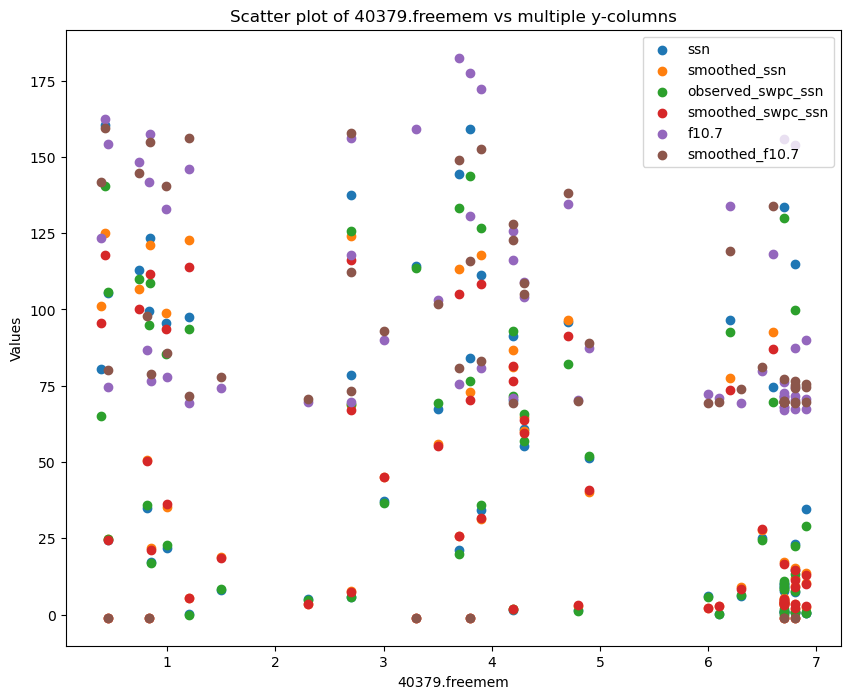

Correlation 40379.median vs ssn: (2.8928015357738235e-17, nan, nan)
Correlation 40379.median vs smoothed_ssn: (3.76514328421923e-18, nan, nan)
Correlation 40379.median vs observed_swpc_ssn: (4.8105662410419635e-17, nan, nan)
Correlation 40379.median vs smoothed_swpc_ssn: (6.426718068920605e-17, nan, nan)
Correlation 40379.median vs f10.7: (3.2417595354086603e-16, nan, nan)
Correlation 40379.median vs smoothed_f10.7: (-6.150202922174086e-17, nan, nan)


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


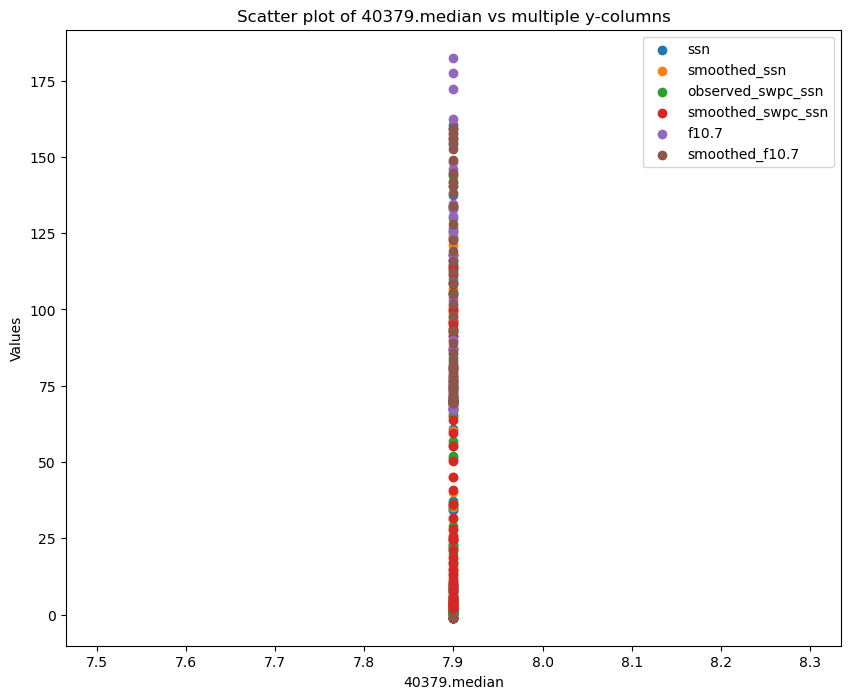

Correlation resets vs ssn: (0.19829777102215387, 0.3122172445117302, 0.38012670904971924)
Correlation resets vs smoothed_ssn: (0.13168100772246627, 0.2553936158761771, 0.21487548268535822)
Correlation resets vs observed_swpc_ssn: (0.20802247306709154, 0.3203171265166223, 0.39284176105244023)
Correlation resets vs smoothed_swpc_ssn: (0.12260484147449434, 0.2548987055691801, 0.2146282727614569)
Correlation resets vs f10.7: (0.21522626002780323, 0.31025714716982605, 0.39564317374162356)
Correlation resets vs smoothed_f10.7: (0.05410464327920527, 0.2956510093789305, 0.22873715836197772)


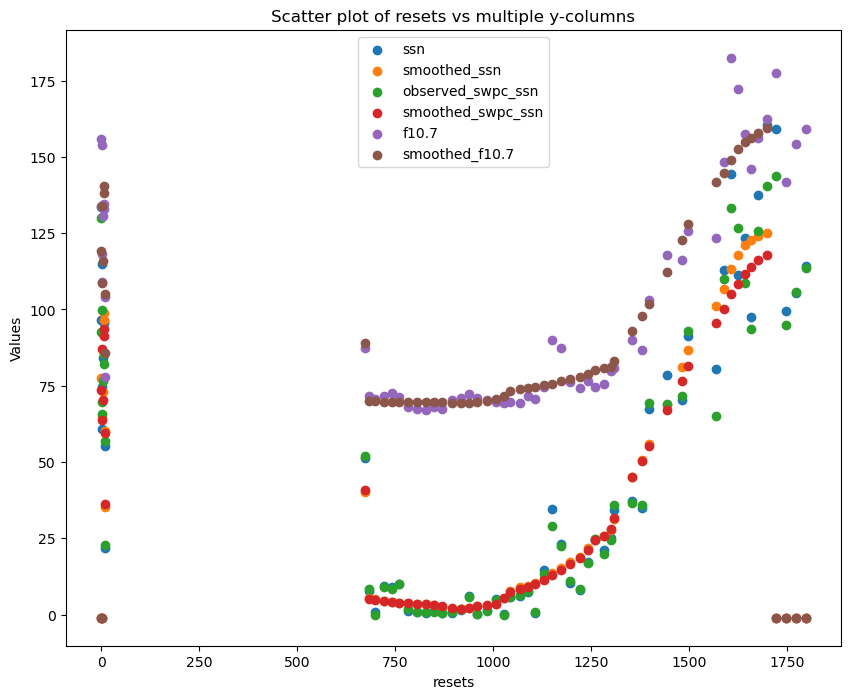

Correlation 40379.min vs ssn: (0.3932620686033009, 0.307522453365607, 0.4594861539400232)
Correlation 40379.min vs smoothed_ssn: (0.3419826250399543, 0.2734404816994579, 0.3915748252677913)
Correlation 40379.min vs observed_swpc_ssn: (0.40024022440192397, 0.3053611793693768, 0.4578442765819006)
Correlation 40379.min vs smoothed_swpc_ssn: (0.34818112178010135, 0.2729327257339162, 0.3910217081843639)
Correlation 40379.min vs f10.7: (0.3631655974361399, 0.2985161405395213, 0.46401701034542203)
Correlation 40379.min vs smoothed_f10.7: (0.15774719814953828, 0.2773974174937626, 0.39731540013551003)


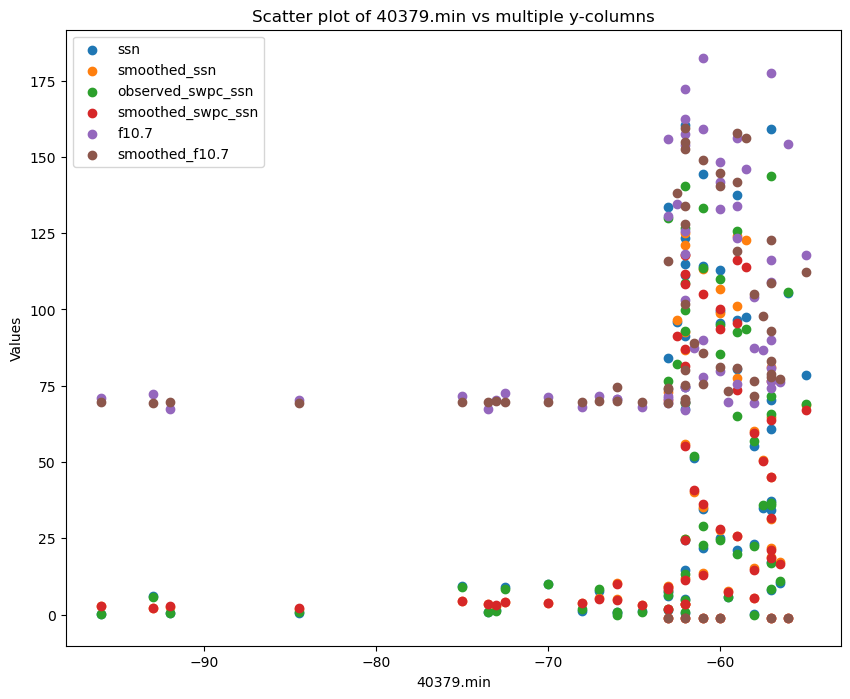

In [9]:
import glob

observed_solar_cycle_data_path = '../data/observed_solar_cycle_indices.json'
griffex_csv_data_files: List[str] = glob.glob(
    os.path.join('../data/griffex', "*.csv"))

for griffex_file in griffex_csv_data_files:
    process(solar_data_file=observed_solar_cycle_data_path,
            satellite_data_file=os.path.abspath(griffex_file))